In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import os
import matplotlib.pyplot as plt
import datetime

# Precinct Shapefile

## VEST's Documentation File

Election results from New Hampshire Secretary of State (https://sos.nh.gov/2016GenResults.aspx)

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

The Census VTD shapefile includes wards for the Town of Berlin and the Town of Derry that are only used for municipal elections. These were merged to match the statewide election returns. The wards for the Town of Laconia were revised to match the 2012 municipal redistricting map.

Results reported across two files, one for the general, one for the presidential primary.

*nh_2016 file*
- G16PRERTRU - Donald J. Trump (Republican Party)
- G16PREDCLI - Hillary Clinton (Democratic Party)
- G16PRELJOH - Gary Johnson (Libertarian Party)
- G16PREGSTE - Jill Stein (Green Party)
- G16PREOFUE - Roque "Rocky" De La Fuente (American Delta Party)
- G16PREOWRI - Write-in Votes


- G16USSRAYO - Kelly Ayotte (Republican Party)
- G16USSDHAS - Maggie Hassan (Democratic Party)
- G16USSLCHA - Brian Chabot (Libertarian Party)
- G16USSIDAY - Aaron Day (Independent)
- G16USSOWRI - Write-in Votes


- G16GOVRSUN - Chris Sununu (Republican Party)
- G16GOVDVAN - Colin Van Ostern (Democratic Party)
- G16GOVLABR - Max Abramson (Libertarian Party)
- G16GOVOWRI - Write-in Votes


## Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nh_2016/nh_2016.shp")

In [3]:
vest_shp.shape

(321, 21)

In [4]:
vest_shp.head(1)

,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16USSRAYO,G16USSDHAS,G16USSLCHA,G16USSIDAY,G16USSOWRI,G16GOVRSUN,G16GOVDVAN,G16GOVLABR,G16GOVOWRI,geometry
0,33,001,ALTO01,TOWN OF ALTON Voting District,TOWN OF ALTON,2201,1152,115,24,2,...,2204,1192,49,69,0,2166,1163,135,14,"POLYGON Z ((-71.34362 43.62879 0.00000, -71.34..."


<AxesSubplot:>

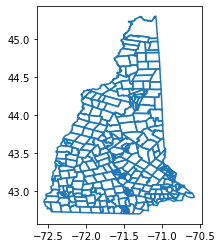

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'NAME', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16PREOWRI',
       'G16USSRAYO', 'G16USSDHAS', 'G16USSLCHA', 'G16USSIDAY', 'G16USSOWRI',
       'G16GOVRSUN', 'G16GOVDVAN', 'G16GOVLABR', 'G16GOVOWRI', 'geometry'],
      dtype='object')

# Loading, Combining Election Results

## Load County Fips File

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Hampshire"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Presidential Results

Had to manually make separate Strafford and Sullivan files, which were combined. Also manually removed summary rows from Belknap county file. 

Reading in the presidential results in separate excel files: 

In [8]:
files = [x for x in os.listdir('./raw-from-source/SOS/general/') if 'president' in x and 'write-ins' not in x]

df_list = []
for f in files: 
    df = pd.read_excel('./raw-from-source/SOS/general/' + f)
    df = df.dropna(how='all')
    df['County'] = f.replace('president-','').replace('-2016-excel.xls','').replace('sum-and-','').capitalize()
    df_list.append(df)
pres_results = pd.concat(df_list, axis = 0, ignore_index = True)
pres_results.columns = ['Precinct','G16PRERTRU','G16PREDCLI','G16PREGSTE','G16PREOFUE','G16PRELJOH','blank','scatter','County']
pres_results['Precinct'] = pres_results['Precinct'].str.strip()
pres_results = pres_results[(pres_results.Precinct != 'TOTALS') & 
                            (~pres_results.G16PRERTRU.str.contains("President",na=False)) & 
                            (pres_results.scatter != 'Scatter') & 
                            (~pres_results.Precinct.str.contains("This is not",na=False)) & 
                            (~pres_results.Precinct.str.contains("correction",na=False)) & 
                            (pres_results.Precinct != '')]
pres_results = pres_results.drop(columns = ['blank','scatter'],)
pres_results['Precinct'] = pres_results['Precinct'].str.replace(r"*","",regex=True)
pres_results.head()

,Precinct,G16PRERTRU,G16PREDCLI,G16PREGSTE,G16PREOFUE,G16PRELJOH,County
2,Albany,182,195,7,2,13,Carroll
3,Bartlett,730,1094,21,0,84,Carroll
4,Brookfield,262,156,3,1,25,Carroll
5,Chatham,103,79,3,0,19,Carroll
6,Conway,2204,2717,57,2,209,Carroll


In [9]:
pres_results.groupby('County')['G16PRERTRU'].sum()

County
Belknap          19315
Carroll          14635
Cheshire         16876
Coos              7952
Grafton          19010
Hillsborough    100013
Merrimack        37674
Rockingham       90447
Strafford        29072
Sullivan         10796
Name: G16PRERTRU, dtype: int64

Reading in the write-in votes all in one excel file: 

In [10]:
write_ins = pd.ExcelFile('./raw-from-source/SOS/general/presidential-write-ins-2016-excel.xls')

excel_tabs = {'BELKNAP':'Belknap','CARROLL':'Carroll','CHESHIRE':'Cheshire',
              'COOS':'Coos','GRAFTON':'Grafton','HILLSBORO':'Hillsborough',
              'MERRIMACK':'Merrimack','ROCKINGHAM':'Rockingham','STRAFFORD':'Strafford','SULLIVAN':'Sullivan'}
df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(write_ins, tab)

#     # Strip all object columns
#     df.columns = ['column_'+str(x) for x in range(len(df.columns))]
#     df['column_0'] = df['column_0'].apply(lambda x: x.str.strip())
    df = df.dropna(how='all')
    
    df['County'] = excel_tabs[tab]
    df.columns = [x for x in range(len(df.columns))]
    df_list.append(df)
write_ins = pd.concat(df_list, axis = 0, ignore_index = True)
write_ins.columns = ['Precinct','Biden, Joe','Booth, Chris','Bowhall, William','Brown, Dana',
                     'Buchanan, Robert','Bush, Jeb','Carlson, Steve','Carson, Ben','Christie, Chris',
                     'Coyne, Thomas','Cruz, Ted','Duncan, Richard','Edgell, Richard','Fox, Cherunda',
                     'Harrell, Sharon','Kasich, John','Kittington, Val','Legan, James','Li, Johnson',
                     'Limbaugh, David','Locke, Star','McCain, John','McMullin, Evan','Morton, Carly',
                     'Paul, Ron or Rand','Pence, Mike','Romney, Mitt','Rubio, Marco','Ryan, Paul',
                     'Sanders, Bernie','Slocum, Michelle','Smith, Coop','Supreme, Vermin',
                     'Tisdale, Lanny','Vakil, Kora Roberta Katz','Scatter','County']
write_ins['Precinct'] = write_ins['Precinct'].str.strip()
write_ins = write_ins[(write_ins.Precinct != 'Totals') & (write_ins.Precinct != 'TOTALS') &
                      (~write_ins["Biden, Joe"].str.contains("Biden",na=False)) & 
                      (write_ins["Precinct"] != datetime.datetime(2016, 11, 8, 0, 0)) &
                      (write_ins.Scatter != 'Scatter') & (write_ins.Precinct != '')]
write_ins.dropna(subset = ['Precinct'], inplace=True)
write_ins.head()

,Precinct,"Biden, Joe","Booth, Chris","Bowhall, William","Brown, Dana","Buchanan, Robert","Bush, Jeb","Carlson, Steve","Carson, Ben","Christie, Chris",...,"Rubio, Marco","Ryan, Paul","Sanders, Bernie","Slocum, Michelle","Smith, Coop","Supreme, Vermin","Tisdale, Lanny","Vakil, Kora Roberta Katz",Scatter,County
2,Alton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,23,Belknap
3,Barnstead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,Belknap
4,Belmont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,2,26,NaN,NaN,2,NaN,NaN,3,Belknap
5,Center Harbor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,1,NaN,NaN,NaN,NaN,NaN,4,Belknap
6,Gilford,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,...,1,NaN,20,NaN,NaN,3,NaN,NaN,9,Belknap


In [11]:
write_ins.groupby('County')['Scatter'].sum()

County
Belknap          91
Carroll          93
Cheshire        137
Coos             66
Grafton         217
Hillsborough    720
Merrimack       261
Rockingham      620
Strafford       161
Sullivan         45
Name: Scatter, dtype: int64

## USS Results

Manually removed the summary counts from the excel file. 

In [12]:
uss_results = pd.ExcelFile('./raw-from-source/SOS/general/us-senator-2016.xls')

excel_tabs = {'belkuss':'Belknap','carruss':'Carroll','chesuss':'Cheshire',
              'coosuss':'Coos','grafuss':'Grafton','hilluss':'Hillsborough',
              'merruss':'Merrimack','rockuss':'Rockingham','strauss':'Strafford','sulluss':'Sullivan'}
df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(uss_results, tab)
    df = df.dropna(how='all')    
    df['County'] = excel_tabs[tab]
    df.columns = [x for x in range(len(df.columns))]
    df_list.append(df)
uss_results = pd.concat(df_list, axis = 0, ignore_index = True)
uss_results.columns = ['Precinct','G16USSRAYO','G16USSDHAS','G16USSLCHA','G16USSIDAY','G16USSOWRI','County']
uss_results['Precinct'] = uss_results['Precinct'].str.strip()
uss_results = uss_results[(uss_results.Precinct != 'Totals') & (uss_results.Precinct != 'TOTALS') &
                      (~uss_results.Precinct.str.contains("correction",na=False)) & 
                      (uss_results["Precinct"] != datetime.datetime(2016, 11, 8, 0, 0)) &
                      (uss_results.G16USSOWRI != 'Scatter') & (uss_results.Precinct != '')]
uss_results['Precinct'] = uss_results['Precinct'].str.replace(r"*","",regex=True)
uss_results.dropna(subset = ['Precinct'], inplace=True)
uss_results.head()

,Precinct,G16USSRAYO,G16USSDHAS,G16USSLCHA,G16USSIDAY,G16USSOWRI,County
2,Alton,2204,1192,49,69,NaN,Belknap
3,Barnstead,1454,1033,52,62,NaN,Belknap
4,Belmont,2008,1503,69,106,4,Belknap
5,Center Harbor,367,328,15,12,2,Belknap
6,Gilford,2497,2065,53,83,2,Belknap


In [13]:
uss_results.groupby('County')['G16USSRAYO'].sum()

County
Belknap          18710
Carroll          14838
Cheshire         16741
Coos              7539
Grafton          20679
Hillsborough    105156
Merrimack        38540
Rockingham       91361
Strafford        29419
Sullivan         10649
Name: G16USSRAYO, dtype: int64

## Governor Results

Manually split up the Strafford and Sullivan county sheets which were combined. Removed summary counts from Belknap sheet. 

Manually removed the summary counts from the excel file. 

In [14]:
files = [x for x in os.listdir('./raw-from-source/SOS/general/') if 'gov' in x]

df_list = []
for f in files: 
    df = pd.read_excel('./raw-from-source/SOS/general/' + f)
    df = df.dropna(how='all')
    df['County'] = f.replace('governor-','').replace('-2016-excel.xls','').replace('summary-and-','').capitalize()
    df_list.append(df)
gov_results = pd.concat(df_list, axis = 0, ignore_index = True)
gov_results.columns = ['Precinct','G16GOVRSUN','G16GOVDVAN','G16GOVLABR','G16GOVOWRI','County']
gov_results['Precinct'] = gov_results['Precinct'].str.strip()
gov_results = gov_results[(gov_results.Precinct != 'TOTALS') & 
                            (~gov_results.G16GOVRSUN.str.contains("Governor",na=False)) & 
                            (gov_results.G16GOVOWRI != 'Scatter') & 
                            (~gov_results.Precinct.str.contains("This is not",na=False)) & 
                            (~gov_results.Precinct.str.contains("correction",na=False)) & 
                            (gov_results.Precinct != '')]
gov_results['Precinct'] = gov_results['Precinct'].str.replace(r"*","",regex=True)
gov_results.head()

,Precinct,G16GOVRSUN,G16GOVDVAN,G16GOVLABR,G16GOVOWRI,County
2,Allenstown,1080,965,115,14,Merrimack
3,Andover,626,728,51,3,Merrimack
4,Boscawen,868,872,81,6,Merrimack
5,Bow,2412,2446,148,7,Merrimack
6,Bradford,472,461,43,6,Merrimack


In [15]:
gov_results.groupby('County')['G16GOVRSUN'].sum()

County
Belknap          18798
Carroll          15192
Cheshire         17107
Coos              7424
Grafton          19685
Hillsborough    103811
Merrimack        37295
Rockingham       94385
Strafford        29578
Sullivan         10765
Name: G16GOVRSUN, dtype: int64

## Combine Results

### Presidential results & write-ins

In [16]:
print(pres_results.shape, write_ins.shape)

(320, 7) (320, 38)


In [17]:
election_results = pres_results.merge(write_ins, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'][['Precinct','County','_merge']].sort_values(['County','Precinct']))

(322, 44)

,Precinct,County,_merge
277,At. & Gil. Academy Grant,Coos,left_only
320,Atkinson & Gilmanton Academy Grant,Coos,right_only
310,Sargent's Purchase,Coos,left_only
321,Sargents Purchase,Coos,right_only


In [18]:
write_ins.loc[write_ins.Precinct == 'Sargents Purchase', "Precinct"] = "Sargent's Purchase"
write_ins.loc[write_ins.Precinct == 'Atkinson & Gilmanton Academy Grant', "Precinct"] = "At. & Gil. Academy Grant"

In [19]:
election_results = pres_results.merge(write_ins, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'][['Precinct','County','_merge']].sort_values(['County','Precinct']))
election_results.head()

(320, 44)

,Precinct,County,_merge


,Precinct,G16PRERTRU,G16PREDCLI,G16PREGSTE,G16PREOFUE,G16PRELJOH,County,"Biden, Joe","Booth, Chris","Bowhall, William",...,"Rubio, Marco","Ryan, Paul","Sanders, Bernie","Slocum, Michelle","Smith, Coop","Supreme, Vermin","Tisdale, Lanny","Vakil, Kora Roberta Katz",Scatter,_merge
0,Albany,182,195,7,2,13,Carroll,NaN,NaN,NaN,...,NaN,NaN,8,NaN,NaN,1,NaN,NaN,2,both
1,Bartlett,730,1094,21,0,84,Carroll,NaN,NaN,NaN,...,1,NaN,16,NaN,NaN,1,NaN,NaN,1,both
2,Brookfield,262,156,3,1,25,Carroll,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
3,Chatham,103,79,3,0,19,Carroll,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
4,Conway,2204,2717,57,2,209,Carroll,NaN,NaN,NaN,...,NaN,9,42,NaN,NaN,NaN,NaN,NaN,9,both


Is Scatter the write-in column? 

In [20]:
vest_shp[vest_shp.NAME == 'TOWN OF ALTON']

,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16USSRAYO,G16USSDHAS,G16USSLCHA,G16USSIDAY,G16USSOWRI,G16GOVRSUN,G16GOVDVAN,G16GOVLABR,G16GOVOWRI,geometry
0,33,001,ALTO01,TOWN OF ALTON Voting District,TOWN OF ALTON,2201,1152,115,24,2,...,2204,1192,49,69,0,2166,1163,135,14,"POLYGON Z ((-71.34362 43.62879 0.00000, -71.34..."


In [21]:
election_results.columns

Index(['Precinct', 'G16PRERTRU', 'G16PREDCLI', 'G16PREGSTE', 'G16PREOFUE',
       'G16PRELJOH', 'County', 'Biden, Joe', 'Booth, Chris',
       'Bowhall, William', 'Brown, Dana', 'Buchanan, Robert', 'Bush, Jeb',
       'Carlson, Steve', 'Carson, Ben', 'Christie, Chris', 'Coyne, Thomas',
       'Cruz, Ted', 'Duncan, Richard', 'Edgell, Richard', 'Fox, Cherunda',
       'Harrell, Sharon', 'Kasich, John', 'Kittington, Val', 'Legan, James',
       'Li, Johnson', 'Limbaugh, David', 'Locke, Star', 'McCain, John',
       'McMullin, Evan', 'Morton, Carly', 'Paul, Ron or Rand', 'Pence, Mike',
       'Romney, Mitt', 'Rubio, Marco', 'Ryan, Paul', 'Sanders, Bernie',
       'Slocum, Michelle', 'Smith, Coop', 'Supreme, Vermin', 'Tisdale, Lanny',
       'Vakil, Kora Roberta Katz', 'Scatter', '_merge'],
      dtype='object')

In [22]:
cols = [x for x in election_results.columns if ',' in x or x == 'Scatter' or 'G16' in x]
for c in cols: 
    election_results[c] = election_results[c].astype(float)
    election_results[c] = election_results[c].fillna(0)
    election_results[c] = election_results[c].astype(int)

Write in are all of the results of all of the column names and Scatter combined. 

In [23]:
election_results['G16PREOWRI'] = election_results['Biden, Joe'] + election_results['Booth, Chris'] + election_results['Bowhall, William'] + election_results[ 'Brown, Dana'] + election_results[ 'Buchanan, Robert'] + election_results[ 'Bush, Jeb'] + election_results['Carlson, Steve'] + election_results[ 'Carson, Ben'] + election_results[ 'Christie, Chris'] + election_results[ 'Coyne, Thomas'] + election_results['Cruz, Ted'] + election_results[ 'Duncan, Richard'] + election_results[ 'Edgell, Richard'] + election_results[ 'Fox, Cherunda'] + election_results['Harrell, Sharon'] + election_results[ 'Kasich, John'] + election_results[ 'Kittington, Val'] + election_results[ 'Legan, James'] + election_results['Li, Johnson'] + election_results[ 'Limbaugh, David'] + election_results[ 'Locke, Star'] + election_results[ 'McCain, John'] + election_results['McMullin, Evan'] + election_results[ 'Morton, Carly'] + election_results[ 'Paul, Ron or Rand'] + election_results[ 'Pence, Mike'] + election_results['Romney, Mitt'] + election_results[ 'Rubio, Marco'] + election_results[ 'Ryan, Paul'] + election_results[ 'Sanders, Bernie'] + election_results['Slocum, Michelle'] + election_results[ 'Smith, Coop'] + election_results[ 'Supreme, Vermin'] + election_results[ 'Tisdale, Lanny'] + election_results['Vakil, Kora Roberta Katz'] + election_results['Scatter']

In [24]:
cols = [x for x in election_results.columns if ',' in x]
election_results.drop(columns = cols + ['_merge'], inplace = True)

### Presidential & senate & governor

In [25]:
election_results = election_results.merge(uss_results, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'][['Precinct','County','_merge']].sort_values(['County','Precinct']))

(320, 15)

,Precinct,County,_merge


In [26]:
election_results.drop(columns = ['_merge'], inplace = True)
election_results = election_results.merge(gov_results, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'][['Precinct','County','_merge']].sort_values(['County','Precinct']))

(320, 19)

,Precinct,County,_merge


In [27]:
cols = [x for x in election_results.columns if 'G16' in x]
for c in cols: 
    election_results[c] = election_results[c].astype(float)
    election_results[c] = election_results[c].fillna(0)
    election_results[c] = election_results[c].astype(int)

# Validating Election Results

## Race Totals

In [28]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'NAME', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16PREOWRI',
       'G16USSRAYO', 'G16USSDHAS', 'G16USSLCHA', 'G16USSIDAY', 'G16USSOWRI',
       'G16GOVRSUN', 'G16GOVDVAN', 'G16GOVLABR', 'G16GOVOWRI', 'geometry'],
      dtype='object')

In [29]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))


data_columns = ['G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16PREOWRI',
       'G16USSRAYO', 'G16USSDHAS', 'G16USSLCHA', 'G16USSIDAY', 'G16USSOWRI',
       'G16GOVRSUN', 'G16GOVDVAN', 'G16GOVLABR', 'G16GOVOWRI']

statewide_totals_check(vest_shp, election_results, data_columns)

***Statewide Totals Check***
G16PRERTRU is equal 	VEST / RDH: 345790
G16PREDCLI is equal 	VEST / RDH: 348526
G16PRELJOH is equal 	VEST / RDH: 30777
G16PREGSTE is equal 	VEST / RDH: 6496
G16PREOFUE is equal 	VEST / RDH: 678
G16PREOWRI is equal 	VEST / RDH: 12029
G16USSRAYO is equal 	VEST / RDH: 353632
G16USSDHAS is equal 	VEST / RDH: 354649
G16USSLCHA is equal 	VEST / RDH: 12597
G16USSIDAY is equal 	VEST / RDH: 17742
G16USSOWRI is equal 	VEST / RDH: 520
G16GOVRSUN is equal 	VEST / RDH: 354040
G16GOVDVAN is equal 	VEST / RDH: 337589
G16GOVLABR is equal 	VEST / RDH: 31243
G16GOVOWRI is equal 	VEST / RDH: 1991


## County-by-County Totals

In [30]:
election_results['COUNTYFP'] = election_results['County'].map(fips_dict)

In [31]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")


               
county_totals_check(vest_shp,election_results,data_columns,'COUNTYFP')

***Countywide Totals Check***

G16PRERTRU is equal across all counties
G16PREDCLI is equal across all counties
G16PRELJOH is equal across all counties
G16PREGSTE is equal across all counties
G16PREOFUE is equal across all counties
G16PREOWRI is equal across all counties
G16USSRAYO is equal across all counties
G16USSDHAS is equal across all counties
G16USSLCHA is equal across all counties
G16USSIDAY is equal across all counties
G16USSOWRI is equal across all counties
G16GOVRSUN is equal across all counties
G16GOVDVAN is equal across all counties
G16GOVLABR is equal across all counties
G16GOVOWRI is equal across all counties


## Precinct-by-Precinct Votes

### Merge VEST and RDH

#### Clean

In [32]:
display(election_results.sort_values('COUNTYFP').head(2))
display(vest_shp.sort_values('COUNTYFP').head(2))

,Precinct,G16PRERTRU,G16PREDCLI,G16PREGSTE,G16PREOFUE,G16PRELJOH,County,Scatter,G16PREOWRI,G16USSRAYO,G16USSDHAS,G16USSLCHA,G16USSIDAY,G16USSOWRI,G16GOVRSUN,G16GOVDVAN,G16GOVLABR,G16GOVOWRI,_merge,COUNTYFP
78,Laconia Ward 4,632,490,19,3,53,Belknap,1,15,555,600,12,35,3,585,544,56,5,both,001
69,Alton,2201,1152,24,2,115,Belknap,23,49,2204,1192,49,69,0,2166,1163,135,14,both,001


,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16USSRAYO,G16USSDHAS,G16USSLCHA,G16USSIDAY,G16USSOWRI,G16GOVRSUN,G16GOVDVAN,G16GOVLABR,G16GOVOWRI,geometry
0,33,001,ALTO01,TOWN OF ALTON Voting District,TOWN OF ALTON,2201,1152,115,24,2,...,2204,1192,49,69,0,2166,1163,135,14,"POLYGON Z ((-71.34362 43.62879 0.00000, -71.34..."
318,33,001,LACO03,LACONIA WARD 3,LACONIA WARD 3,604,637,49,12,0,...,629,658,21,21,4,625,628,49,1,"POLYGON Z ((-71.51071 43.54764 0.00000, -71.51..."


In [33]:
len(vest_shp['NAME'].unique())

321

In [34]:
len(election_results['Precinct'].unique())

320

In [35]:
vest_shp['join_col'] = vest_shp['COUNTYFP'] + vest_shp['NAME'].str.replace('TOWN OF ','').str.replace('TOWNSHIP OF ','').str.lower()
election_results['join_col'] = election_results['COUNTYFP'] + election_results['Precinct'].str.replace("'","").str.lower()

In [36]:
election_results.drop(columns = ['_merge'], inplace = True)

#### Join Attempt #1

In [37]:
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County','_merge']]

,join_col,County,_merge
57,007atkinson and gilmanton academy grant,NaN,left_only
81,007low and burbanks grant,NaN,left_only
96,007thompson and meserves purchase,NaN,left_only
97,007wentworth location,NaN,left_only
268,015not defined,NaN,left_only
314,007berlin wards 1-3,NaN,left_only
315,015derry wards 1-4,NaN,left_only
321,015derry,Rockingham,right_only
322,007at. & gil. academy grant,Coos,right_only
323,007berlin,Coos,right_only


In [38]:
election_results.loc[election_results['join_col'] == "015derry", 'join_col'] = "015derry wards 1-4"
election_results.loc[election_results['join_col'] == "007at. & gil. academy grant", 'join_col'] = "007atkinson and gilmanton academy grant"
election_results.loc[election_results['join_col'] == "007berlin", 'join_col'] = "007berlin wards 1-3"
election_results.loc[election_results['join_col'] == "007low & burbanks grant", 'join_col'] = "007low and burbanks grant"
election_results.loc[election_results['join_col'] == "007thompson & meserves pur.", 'join_col'] = "007thompson and meserves purchase"
election_results.loc[election_results['join_col'] == "007wentworths location", 'join_col'] = "007wentworth location"

#### Join Attempt #2

In [39]:
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County']]

,join_col,County
268,015not defined,NaN


In [40]:
vest_shp[vest_shp['join_col'] == '015not defined']

,STATEFP,COUNTYFP,VTDST,NAMELSAD,NAME,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16USSDHAS,G16USSLCHA,G16USSIDAY,G16USSOWRI,G16GOVRSUN,G16GOVDVAN,G16GOVLABR,G16GOVOWRI,geometry,join_col
268,33,015,ZZZZZZ,not defined,not defined,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-70.69464 42.95636 0.00000, ...",015not defined


### Validate

In [41]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [42]:
# Replace nan votes with 0 votes
for col in data_columns: 
    merge_df[col + '_y'] = merge_df[col + '_y'].fillna(0)


precinct_votes_check(merge_df,data_columns,True,'join_col',print_level=0)


There are  321  total rows
0  of these rows have election result differences
321  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
